In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
import warnings
warnings.filterwarnings('ignore')
import sidetable
import statsmodels.api as sm
from scipy.stats import skew
from scipy.stats import kurtosistest
from scipy import stats
from scipy.stats import kstest
import math 

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

pd.options.display.max_columns = None

In [2]:
df_bikes_tests = pd.read_csv("datos/bikes_EDA.csv", index_col=0)
df_bikes_tests.head(6)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,registered
0,2018-01-01,winter,0,1,1,Monday,0,2,14.110847,80.5833,10.749882,654
1,2018-01-02,winter,0,1,0,Tuesday,1,2,14.902598,69.6087,16.652113,670
2,2018-01-03,winter,0,1,0,Wednesday,1,1,8.050924,43.7273,16.636703,1229
3,2018-01-04,winter,0,1,0,Thursday,1,1,8.200000,59.0435,10.739832,1454
4,2018-01-05,winter,0,1,0,Friday,1,1,9.305237,43.6957,12.522300,1518
5,2018-01-06,winter,0,1,0,Saturday,0,1,8.378268,51.8261,6.000868,1518


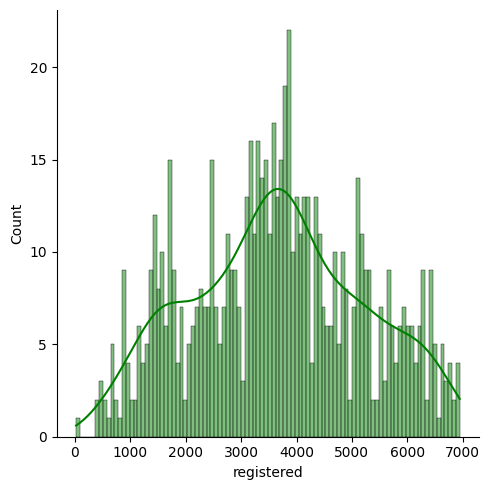

In [3]:
sns.displot(df_bikes_tests['registered'], kde = True, color = "green", bins=100);

Usamos el test de shapiro para comprobar normalidad porque solo tenemos 730 datos.

In [4]:
stats.shapiro(df_bikes_tests["registered"])

ShapiroResult(statistic=0.9843854308128357, pvalue=5.023125027037167e-07)

pvalue < 0.05 - luego nuetros datos no son normales

## Normalización de la VR

1. Normalización manual

In [5]:
media = df_bikes_tests["registered"].mean()
maximo = df_bikes_tests["registered"].max() 
minimo = df_bikes_tests["registered"].min()

In [6]:
df_bikes_tests["registered_NORM"] = (df_bikes_tests["registered"] - media) / (maximo - minimo )

In [7]:
df_bikes_tests.head(2)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,registered,registered_NORM
0,2018-01-01,winter,0,1,1,Monday,0,2,14.110847,80.5833,10.749882,654,-0.433837
1,2018-01-02,winter,0,1,0,Tuesday,1,2,14.902598,69.6087,16.652113,670,-0.431527


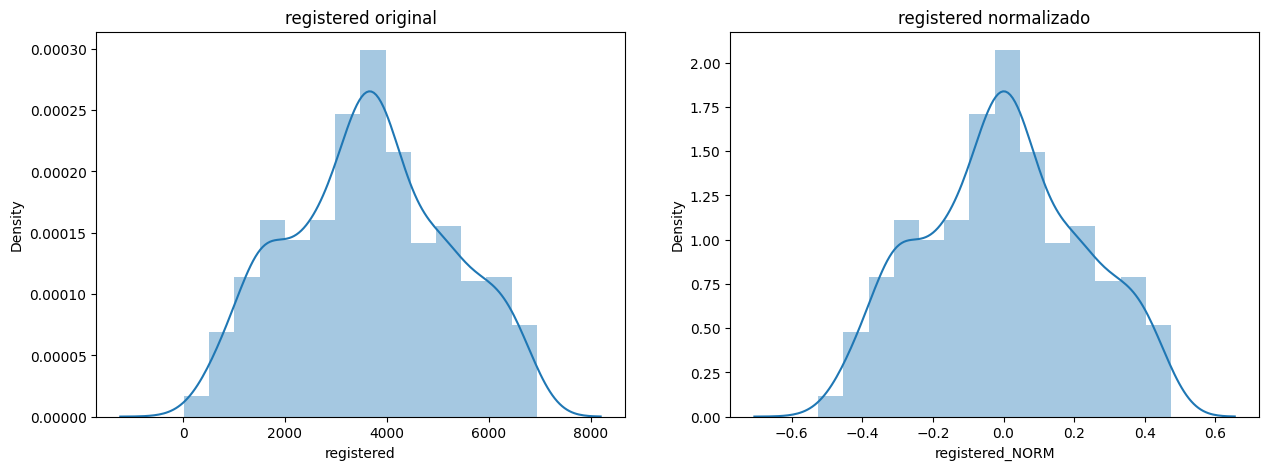

In [8]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('registered original')
axes[1].set_title('registered normalizado')

sns.distplot(df_bikes_tests['registered'] ,ax = axes[0])
sns.distplot(df_bikes_tests["registered_NORM"], ax = axes[1]);

In [9]:
stats.shapiro(df_bikes_tests["registered_NORM"])

ShapiroResult(statistic=0.9843854308128357, pvalue=5.023125027037167e-07)

La normalización manual no nos sirve. Probamos la logarítmica.

2. Normalización Logarítmica

In [10]:
df_bikes_tests["registered_LOG"] = df_bikes_tests["registered"].apply(lambda x: np.log(x) if x > 0 else 0)

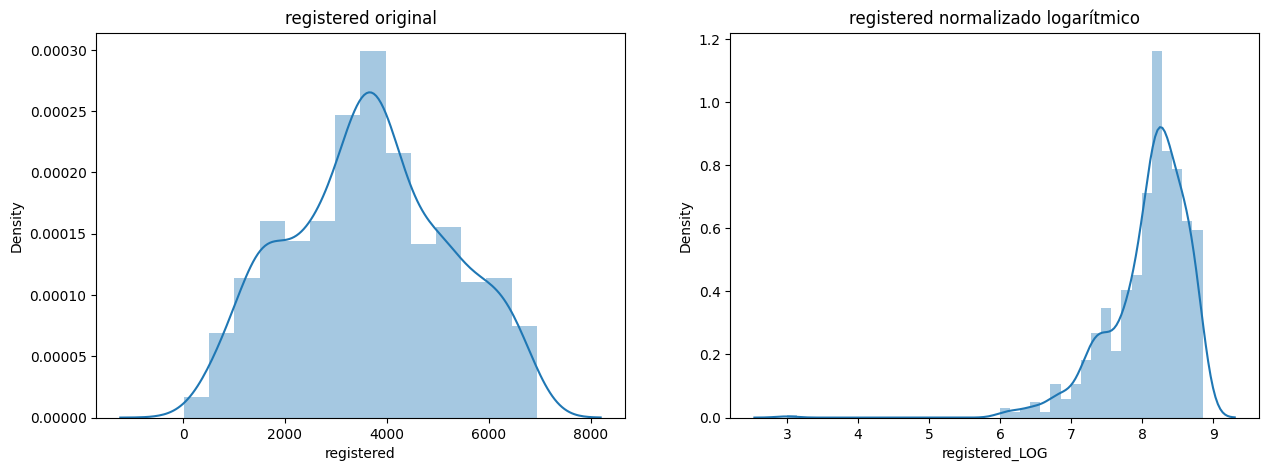

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('registered original')
axes[1].set_title('registered normalizado logarítmico')

sns.distplot(df_bikes_tests["registered"] ,ax = axes[0])
sns.distplot(df_bikes_tests["registered_LOG"], ax = axes[1]);

In [12]:
stats.shapiro(df_bikes_tests["registered_LOG"])

ShapiroResult(statistic=0.8750756978988647, pvalue=9.983904080289458e-24)

La normalización logarítmica no funciona; probamos la raíz cuadrada.

3. Normalización Raíz Cuadrada 

In [13]:
df_bikes_tests["registered_RAIZ"] = df_bikes_tests["registered"].apply(lambda x: math.sqrt(x))

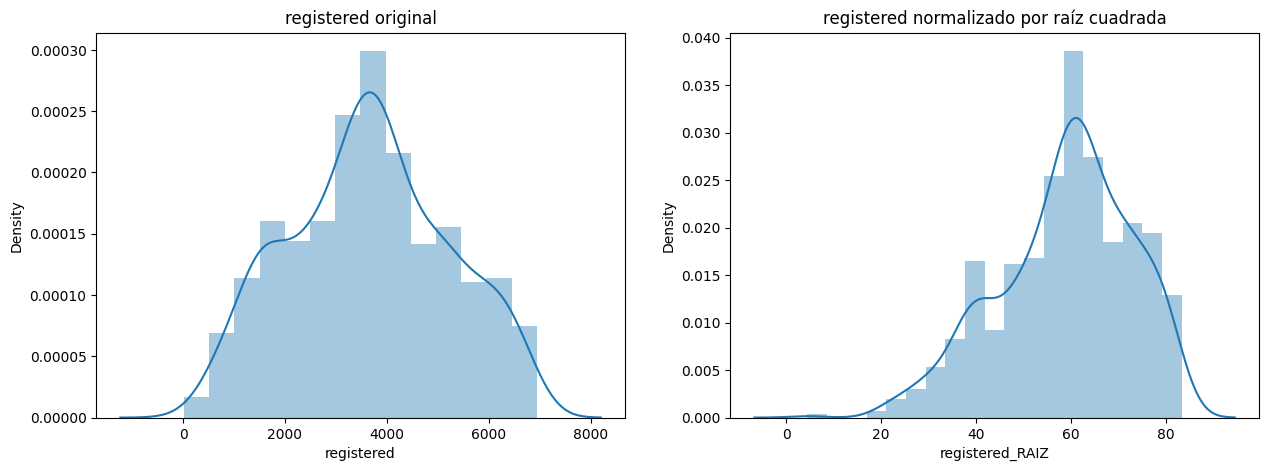

In [14]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('registered original')
axes[1].set_title('registered normalizado por raíz cuadrada')

sns.distplot(df_bikes_tests["registered"] ,ax = axes[0])
sns.distplot(df_bikes_tests["registered_RAIZ"], ax = axes[1]);

In [15]:
stats.shapiro(df_bikes_tests["registered_RAIZ"])

ShapiroResult(statistic=0.9734112620353699, pvalue=2.976442425861592e-10)

No funciona la normalización por raíz cuadrada. Probamos por boxcox.

4.  Normalización Boxcox

In [16]:
df_bikes_tests['registered_BOX'], lambda_ajustada = stats.boxcox(df_bikes_tests['registered'])

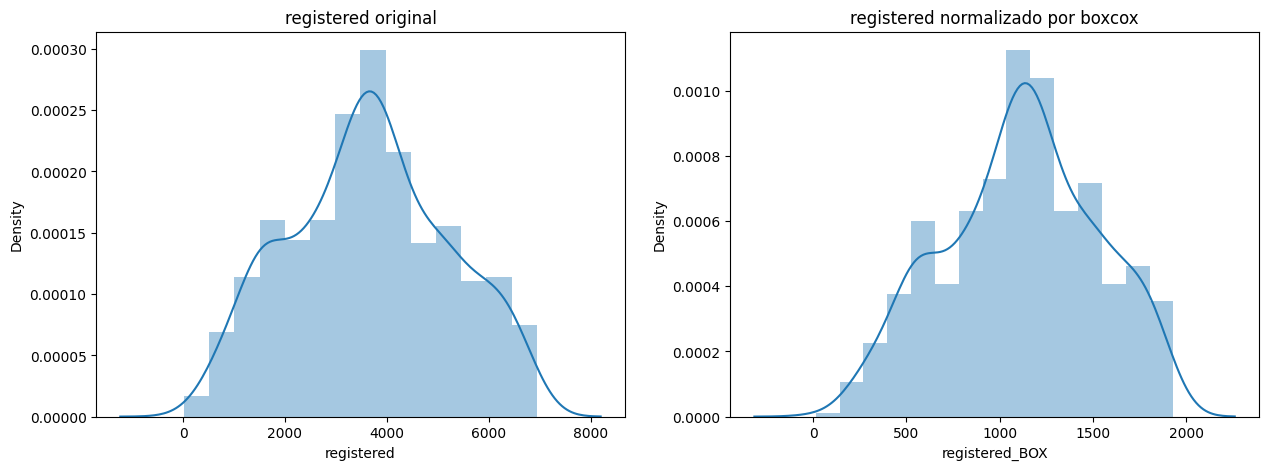

In [17]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('registered original')
axes[1].set_title('registered normalizado por boxcox')

sns.distplot(df_bikes_tests['registered'] ,ax = axes[0])
sns.distplot(df_bikes_tests['registered_BOX'], ax = axes[1]);

In [18]:
stats.shapiro(df_bikes_tests["registered_BOX"])

ShapiroResult(statistic=0.9854223132133484, pvalue=1.163151068794832e-06)

No podemos normalizar nuestra variable. Por ello, 

### un modelo de regresión lineal no será apropiado en este caso.

Debido a que nuestra variable respuesta no cumple con la asunción de normalidad necesaria para el modelo de regresión lineal, no continuamos con las asunciones y pasamos a un modelo de decision tree o random forest.

In [19]:
df_numericas = df_bikes_tests.filter(['temp', 'hum', 'windspeed'])
df_numericas

,temp,hum,windspeed
0,14.110847,80.5833,10.749882
1,14.902598,69.6087,16.652113
2,8.050924,43.7273,16.636703
3,8.200000,59.0435,10.739832
4,9.305237,43.6957,12.522300
...,...,...,...
725,10.420847,65.2917,23.458911
726,10.386653,59.0000,10.416557
727,10.386653,75.2917,8.333661
728,10.489153,48.3333,23.500518


In [20]:
# covarianza
df_numericas.cov()

,temp,hum,windspeed
temp,56.350979,13.740700,-6.169865
hum,13.740700,202.708942,-18.383531
windspeed,-6.169865,-18.383531,26.996761


In [21]:
# correlacion
df_correl = df_numericas.corr(method='spearman')
df_correl

,temp,hum,windspeed
temp,1.000000,0.131518,-0.147233
hum,0.131518,1.000000,-0.239451
windspeed,-0.147233,-0.239451,1.000000


## Estandarización de las VPs

Como tenemos un 2% de outliers y decidimos mantenerlos para no perder datos, vamos a utilizar el método RobustScaler de estandarización de VPs

- Robust Scaler

In [22]:

robust = RobustScaler()

In [23]:
robust.fit(df_numericas)

RobustScaler()

In [24]:
X_robust = robust.transform(df_numericas)

In [25]:
df_numericas_robust = pd.DataFrame(X_robust, columns = df_numericas.columns)
df_numericas_robust.head(2)

,temp,hum,windspeed
0,-0.486274,0.855582,-0.208909
1,-0.425690,0.332722,0.687550


In [26]:
for columna in df_numericas_robust.columns:
    print(f'La media de la columna {columna} es:  {df_numericas_robust[columna].mean()}')
    print(f'La desviación estándar de la columna {columna} es: {df_numericas_robust[columna].std()}')
    print("-------------------------------------------------------------")

La media de la columna temp es:  -0.01121511337530535
La desviación estándar de la columna temp es: 0.5744038804193734
-------------------------------------------------------------
La media de la columna hum es:  0.006678312043328619
La desviación estándar de la columna hum es: 0.6783171666603843
-------------------------------------------------------------
La media de la columna windspeed es:  0.09694722724811505
La desviación estándar de la columna windspeed es: 0.7891689924205268
-------------------------------------------------------------


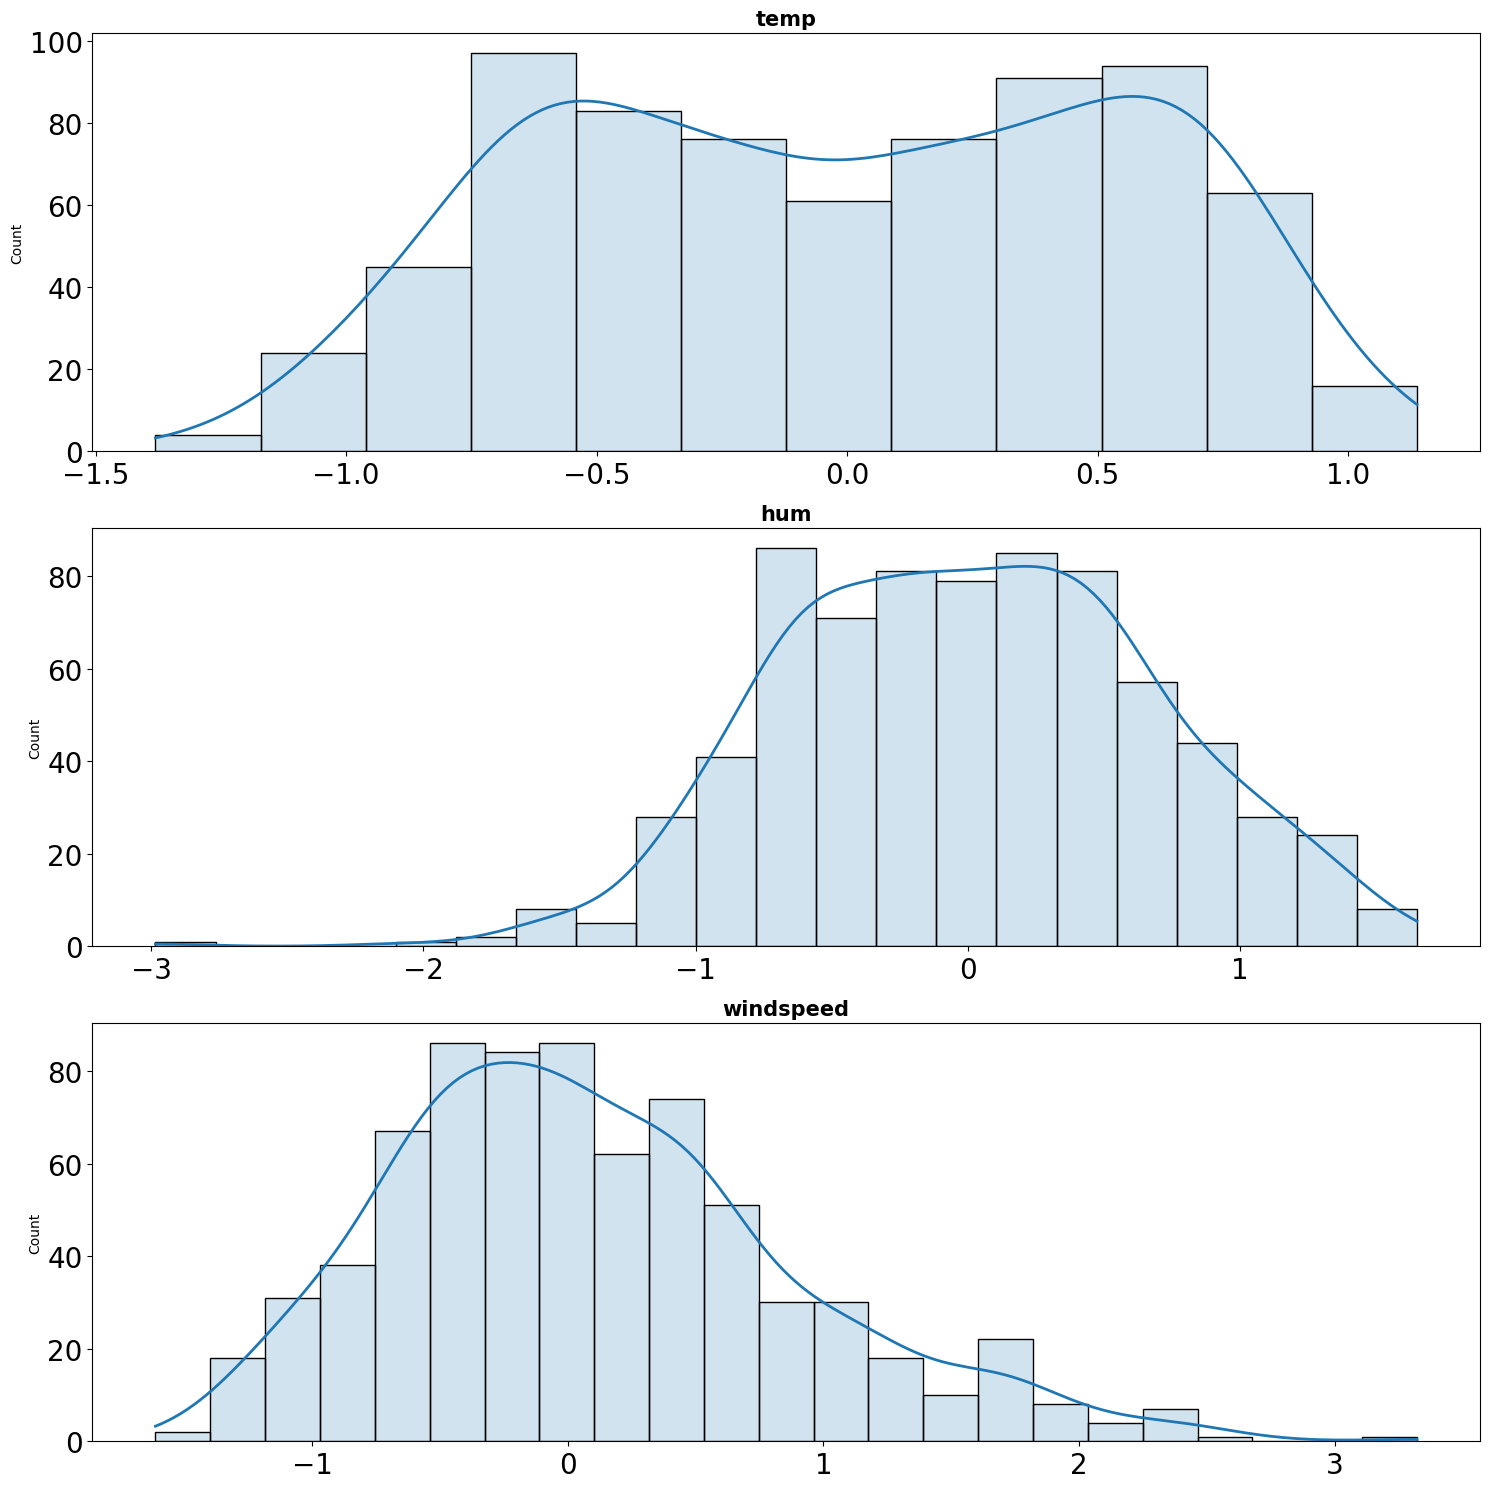

In [27]:
fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (15, 15))

columnas_robust = df_numericas_robust.columns
axes = axes.flat


for i, colum in enumerate(columnas_robust): 
    sns.histplot(
        data = df_numericas_robust,
        x = colum,
        kde = True,  
        line_kws = {"linewidth": 2}, 
        alpha = 0.2, 
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")

fig.tight_layout();

In [28]:
df_bikes_tests[df_numericas_robust.columns] = df_numericas_robust

In [29]:
df_bikes_tests.head(3)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,registered,registered_NORM,registered_LOG,registered_RAIZ,registered_BOX
0,2018-01-01,winter,0,1,1,Monday,0,2,-0.486274,0.855582,-0.208909,654,-0.433837,6.483107,25.573424,267.555885
1,2018-01-02,winter,0,1,0,Tuesday,1,2,-0.425690,0.332722,0.687550,670,-0.431527,6.507278,25.884358,273.035135
2,2018-01-03,winter,0,1,0,Wednesday,1,1,-0.949970,-0.900337,0.685210,1229,-0.350817,7.113956,35.057096,453.922956


In [30]:
lista=["registered_LOG","registered_RAIZ","registered_BOX","registered_NORM"]
df_bikes_tests.drop(lista, axis=1, inplace=True)

In [31]:
df_bikes_tests.head(3)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,registered
0,2018-01-01,winter,0,1,1,Monday,0,2,-0.486274,0.855582,-0.208909,654
1,2018-01-02,winter,0,1,0,Tuesday,1,2,-0.425690,0.332722,0.687550,670
2,2018-01-03,winter,0,1,0,Wednesday,1,1,-0.949970,-0.900337,0.685210,1229


In [32]:
df_bikes_tests.to_csv("datos/bikes_stand.csv")